# A computational introduction to stochastic differential equations.

Lecture 6.

https://github.com/spdes/computational-sde-intro-lecture.

Kalman filtering and RTS smoothing on a motion model. See Lecture note 6.

In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import math
from typing import Tuple

np.random.seed(666)

In [2]:
def discretise_lti_sde(A: np.ndarray, B: np.ndarray, dt: float) -> Tuple[np.ndarray, np.ndarray]:
    """See the docstring in `lec5_linear_sde_mean_cov.ipynb`.
    """
    d = A.shape[0]

    F = scipy.linalg.expm(A * dt)
    phi = np.vstack([np.hstack([A, B @ B.T]), np.hstack([np.zeros_like(A), -A.T])])
    AB = scipy.linalg.expm(phi * dt) @ np.vstack([np.zeros_like(A), np.eye(d)])
    cov = AB[0:d, :] @ F.T
    return F, cov

In [3]:
# Dimensions of the state and measurement variables
dim_x = 4
dim_y = 2

# SDE coefficients
A = np.array([[0., 1., 0., 0.],
              [0., 0., 0., 0.],
              [0., 0., 0., 1.],
              [0., 0., 0., 0.]])
B = np.array([[0., 0.],
              [1., 0.],
              [0., 0.],
              [0., 1.]])

# Measurement model coefficients
H = np.array([[1., 0., 0., 0.],
              [0., 0., 1., 0.]])

# Measurement noise covariance
Xi = np.eye(dim_y)

# Initial mean and covariance
m0 = np.zeros((dim_x,))
V0 = np.eye(dim_x)

In [4]:
# Times
T = 100
dt = 0.1
ts = np.linspace(dt, dt * T, T)

# Discretise the SDE at the times
# Since the times are uniformly placed, we don't need to do this
# every time in the filtering loop
F, Sigma = discretise_lti_sde(A, B, dt)
chol = np.linalg.cholesky(Sigma)

Now we generate a pair of trajectory and its measurements at the times.

In [5]:
# Generate initial value
x0 = m0 + np.linalg.cholesky(V0) @ np.random.randn(dim_x)

# Results accumulator
xs = np.zeros((T, dim_x))
ys = np.zeros((T, dim_y))

# Simulate SDE at the times
x = x0.copy()
for k in range(T):
    x = F @ x + chol @ np.random.randn(dim_x)
    y = H @ x + np.random.randn(dim_y)
    xs[k] = x
    ys[k] = y

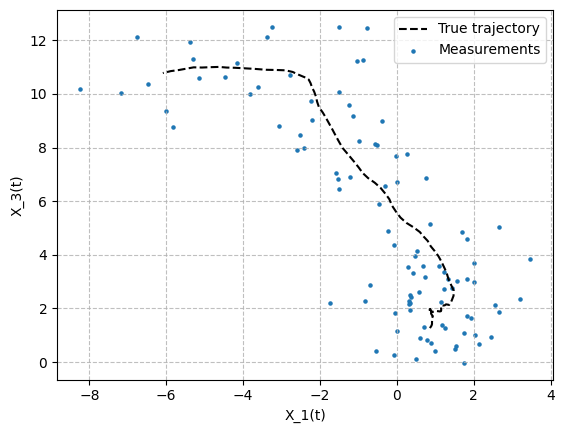

In [6]:
plt.plot(xs[:, 0], xs[:, 2], c='black', linestyle='--', label='True trajectory')
plt.scatter(ys[:, 0], ys[:, 1], s=5, label='Measurements')
plt.legend()
plt.xlabel('X_1(t)')
plt.ylabel('X_3(t)')
plt.grid(linestyle='--', alpha=0.8, which='both')

Now we implement Kalman filter and smoother as per the algorithms in Lecture 6.

In [7]:
def log_mvn_pdf(x, mu, chol_factor) -> float:
    """Efficient computation of log multivariate Normal N(x | mu, S) when the Cholesky decom of S is given.
    """
    chol, lower = chol_factor
    z = scipy.linalg.solve_triangular(chol, x - mu, lower=lower)
    return -0.5 * (np.dot(z, z) + 2 * np.sum(np.log(math.sqrt(2 * math.pi) * np.diagonal(chol))))


def kf(ys):
    """Kalman filter.
    """
    # Accumulators for filtering means and covariances
    mfs = np.zeros((T, dim_x))
    Vfs = np.zeros((T, dim_x, dim_x))

    mf = m0.copy()
    Vf = V0.copy()
    n_ell = 0.

    for k in range(T):
        # Note that if the time interval dt changes, we have to recompute F and Sigma.
        mp = F @ mf
        Vp = F @ Vf @ F.T + Sigma

        S = H @ Vp @ H.T + Xi
        chol = scipy.linalg.cho_factor(S)
        K = Vp @ scipy.linalg.cho_solve(chol, H).T

        mf = mp + K @ (ys[k] - H @ mp)
        Vf = Vp - K @ S @ K.T
        n_ell -= log_mvn_pdf(ys[k], H @ mp, chol)

        mfs[k] = mf
        Vfs[k] = Vf
    return mfs, Vfs, n_ell


def rts(mfs, Vfs):
    """RTS smoother.
    """
    # Accumulators for smoothing means and covariances
    mss = np.zeros((T, dim_x))
    Vss = np.zeros((T, dim_x, dim_x))

    ms = mfs[-1]
    Vs = Vfs[-1]

    mss[-1] = ms
    Vss[-1] = Vs

    for k in range(T - 2, -1, -1):
        # Note that mp and Vp are computed in the filtering routine already; you can reuse them.
        mp = F @ mfs[k]
        Vp = F @ Vfs[k] @ F.T + Sigma

        chol = scipy.linalg.cho_factor(Vp)
        G = Vfs[k] @ scipy.linalg.cho_solve(chol, F).T
        ms = mfs[k] + G @ (ms - mp)
        Vs = Vfs[k] + G @ (Vs - Vp) @ G.T

        mss[k] = ms
        Vss[k] = Vs
    return mss, Vss

We then run the filter and smoother.

In [8]:
mfs, Vfs, n_ell = kf(ys)
mss, Vss = rts(mfs, Vfs)

Plot

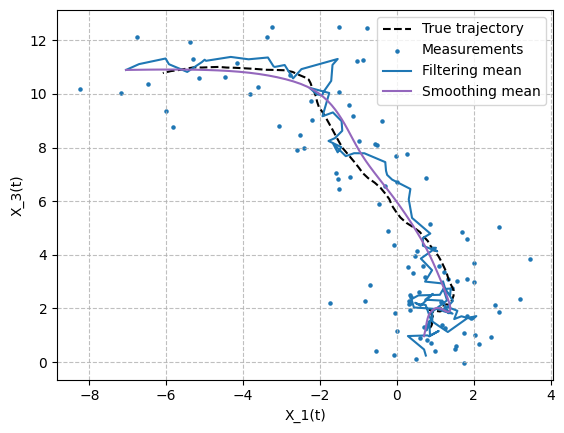

In [9]:
plt.plot(xs[:, 0], xs[:, 2], c='black', linestyle='--', label='True trajectory')
plt.scatter(ys[:, 0], ys[:, 1], s=5, label='Measurements')
plt.plot(mfs[:, 0], mfs[:, 2], c='tab:blue', label='Filtering mean')
plt.plot(mss[:, 0], mss[:, 2], c='tab:purple', label='Smoothing mean')

plt.legend()
plt.xlabel('X_1(t)')
plt.ylabel('X_3(t)')
plt.grid(linestyle='--', alpha=0.8, which='both')

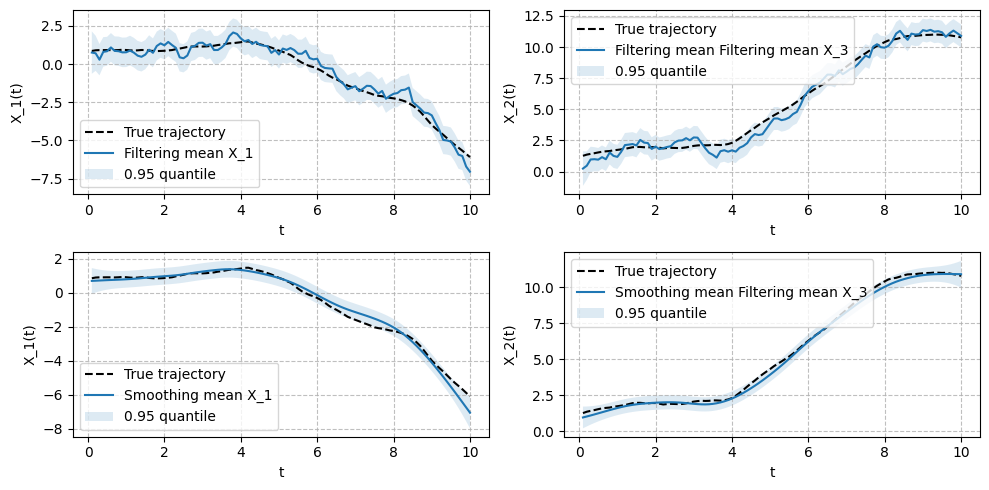

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
axes[0, 0].plot(ts, xs[:, 0], c='black', linestyle='--', label='True trajectory')
axes[0, 0].plot(ts, mfs[:, 0], c='tab:blue', label='Filtering mean X_1')
axes[0, 0].fill_between(ts,
                     mfs[:, 0] - 1.96 * np.sqrt(np.squeeze(Vfs[:, 0, 0])),
                     mfs[:, 0] + 1.96 * np.sqrt(np.squeeze(Vfs[:, 0, 0])),
                     color='tab:blue',
                     edgecolor='none',
                     alpha=0.15,
                     label='0.95 quantile')
axes[0, 0].set_xlabel('t')
axes[0, 0].set_ylabel('X_1(t)')
axes[0, 0].grid(linestyle='--', alpha=0.8, which='both')
axes[0, 0].legend()

axes[0, 1].plot(ts, xs[:, 2], c='black', linestyle='--', label='True trajectory')
axes[0, 1].plot(ts, mfs[:, 2], c='tab:blue', label='Filtering mean Filtering mean X_3')
axes[0, 1].fill_between(ts,
                     mfs[:, 2] - 1.96 * np.sqrt(np.squeeze(Vfs[:, 2, 2])),
                     mfs[:, 2] + 1.96 * np.sqrt(np.squeeze(Vfs[:, 2, 2])),
                     color='tab:blue',
                     edgecolor='none',
                     alpha=0.15,
                     label='0.95 quantile')
axes[0, 1].set_xlabel('t')
axes[0, 1].set_ylabel('X_2(t)')
axes[0, 1].grid(linestyle='--', alpha=0.8, which='both')
axes[0, 1].legend()

axes[1, 0].plot(ts, xs[:, 0], c='black', linestyle='--', label='True trajectory')
axes[1, 0].plot(ts, mss[:, 0], c='tab:blue', label='Smoothing mean X_1')
axes[1, 0].fill_between(ts,
                     mss[:, 0] - 1.96 * np.sqrt(np.squeeze(Vss[:, 0, 0])),
                     mss[:, 0] + 1.96 * np.sqrt(np.squeeze(Vss[:, 0, 0])),
                     color='tab:blue',
                     edgecolor='none',
                     alpha=0.15,
                     label='0.95 quantile')
axes[1, 0].set_xlabel('t')
axes[1, 0].set_ylabel('X_1(t)')
axes[1, 0].grid(linestyle='--', alpha=0.8, which='both')
axes[1, 0].legend()

axes[1, 1].plot(ts, xs[:, 2], c='black', linestyle='--', label='True trajectory')
axes[1, 1].plot(ts, mss[:, 2], c='tab:blue', label='Smoothing mean Filtering mean X_3')
axes[1, 1].fill_between(ts,
                     mss[:, 2] - 1.96 * np.sqrt(np.squeeze(Vss[:, 2, 2])),
                     mss[:, 2] + 1.96 * np.sqrt(np.squeeze(Vss[:, 2, 2])),
                     color='tab:blue',
                     edgecolor='none',
                     alpha=0.15,
                     label='0.95 quantile')
axes[1, 1].set_xlabel('t')
axes[1, 1].set_ylabel('X_2(t)')
axes[1, 1].grid(linestyle='--', alpha=0.8, which='both')
axes[1, 1].legend()

plt.tight_layout()

In [11]:
n_ell

321.8851417376908